In [1]:
"""
Created on Thu Oct 27 00:07:46 2016

@author: Murasaki
"""

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
from collections import Counter
matplotlib.style.use('ggplot')

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings('ignore')

datas = pd.read_csv('./predictemall/300k.csv', low_memory=True)


In [2]:
"""
Preprocessing
"""

# Pokemon rareness
rareId = [1,2,3,4,5,6,7,8,9,25,26,27,28,35,36,37,38,39,50,51,52,53,54,55,56,
          63,64,65,66,67,68,72,73,74,75,76,77,78,79,80,81,82,86,87,90,91,95,
          100,101,102,103,104,105,109,110,111,112,114,116,117,118,119,123,124,
          125,126,128,134,135,136,138,139,140,141,143,147,148,149]
          
veryRareId = [88,89,106,107,108,113,130,137,142,83,132,144,145,146,150,151,
              115,122,131]

# Set rareness        
rareness = []
pokeId = datas.pokemonId.to_dict()
for i in pokeId:
    if pokeId[i] in rareId:
        rareness.append(1)
    elif pokeId[i] in veryRareId:
        rareness.append(2)
    else:
        rareness.append(0)
datas['rareness'] = rareness

# Combine hours:mins to mins
datas['minPassedToday'] = datas['appearedHour']*60 + datas['appearedMinute']

# Encode numerical feature
label_encoder = preprocessing.LabelEncoder()
datas['cityNum'] = label_encoder.fit_transform(datas['city'])
datas['continentNum'] = label_encoder.fit_transform(datas['continent'])
datas['weatherNum'] = label_encoder.fit_transform(datas['weather'])
datas['weatherIconNum'] = label_encoder.fit_transform(datas['weatherIcon'])
datas['closeToWaterNum'] = label_encoder.fit_transform(datas['closeToWater'])

# Features choosed for learning
SUBSET = ['latitude', 'longitude', 'minPassedToday', 'gymDistanceKm', 
          'population_density']            
ALL = ['latitude', 'longitude', 'minPassedToday', 'gymDistanceKm', 
            'population_density', 'cityNum', 'continentNum',
            'weatherNum', 'weatherIconNum', 'closeToWaterNum', 'terrainType'] 
   
# Feature Normalization
featureSelected = []
scaler = preprocessing.StandardScaler()
for i in ALL:
    tempFeature = datas[i].as_matrix()
    tempFeature = scaler.fit_transform(tempFeature)
    datas[i+'Norm'] = tempFeature
    featureSelected.append(i+'Norm')

# Training set and Testing set construction
train, test = train_test_split(datas, test_size = 0.2)
    

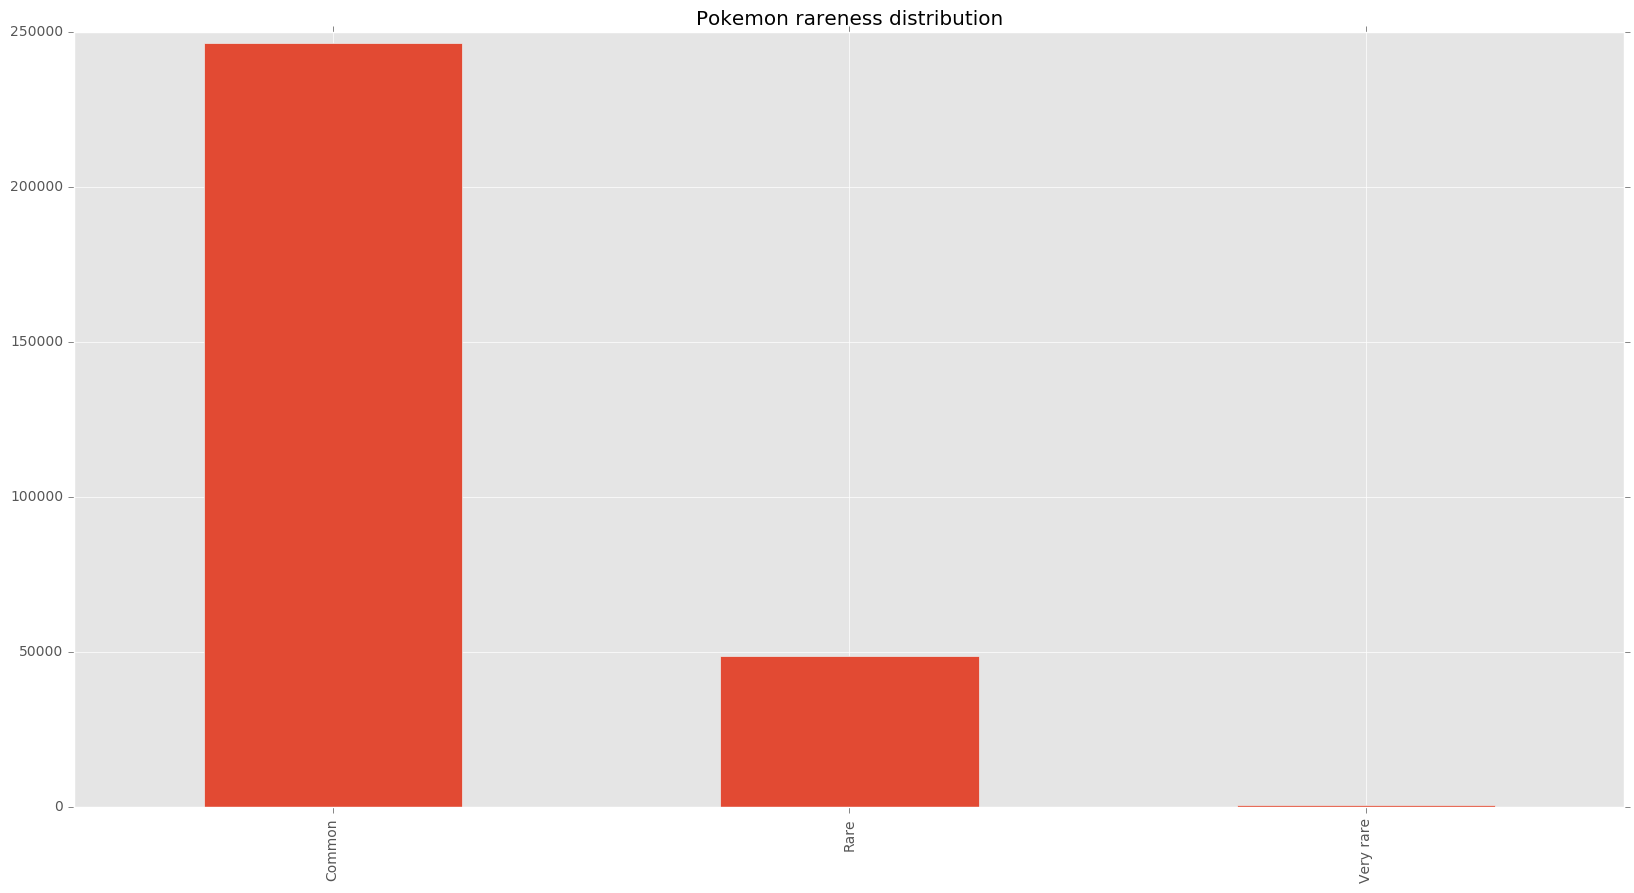

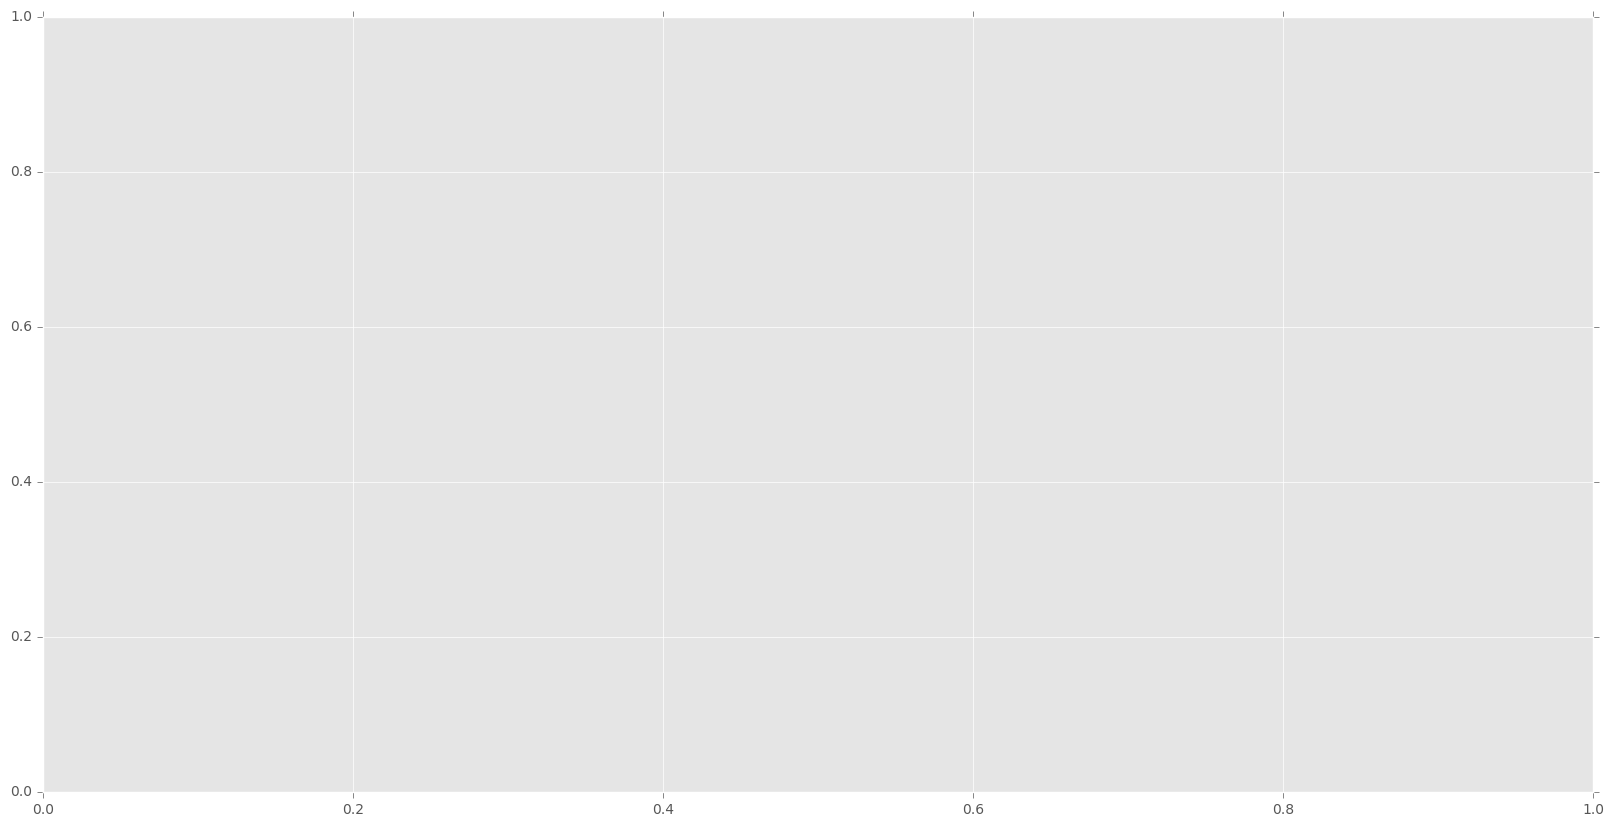

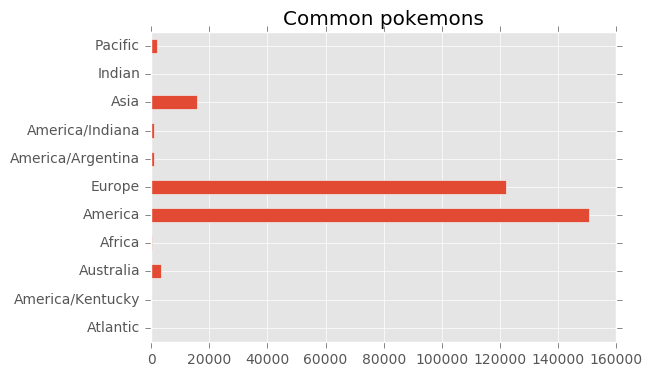

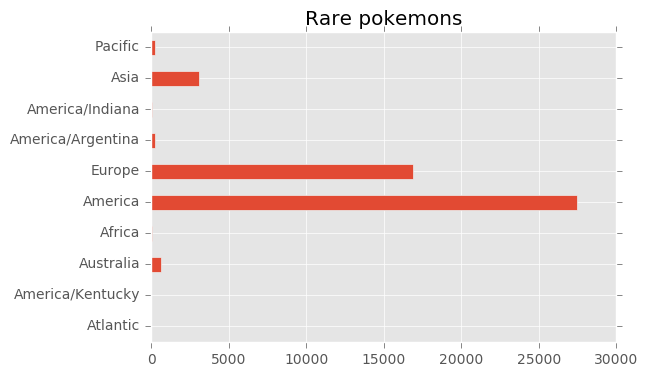

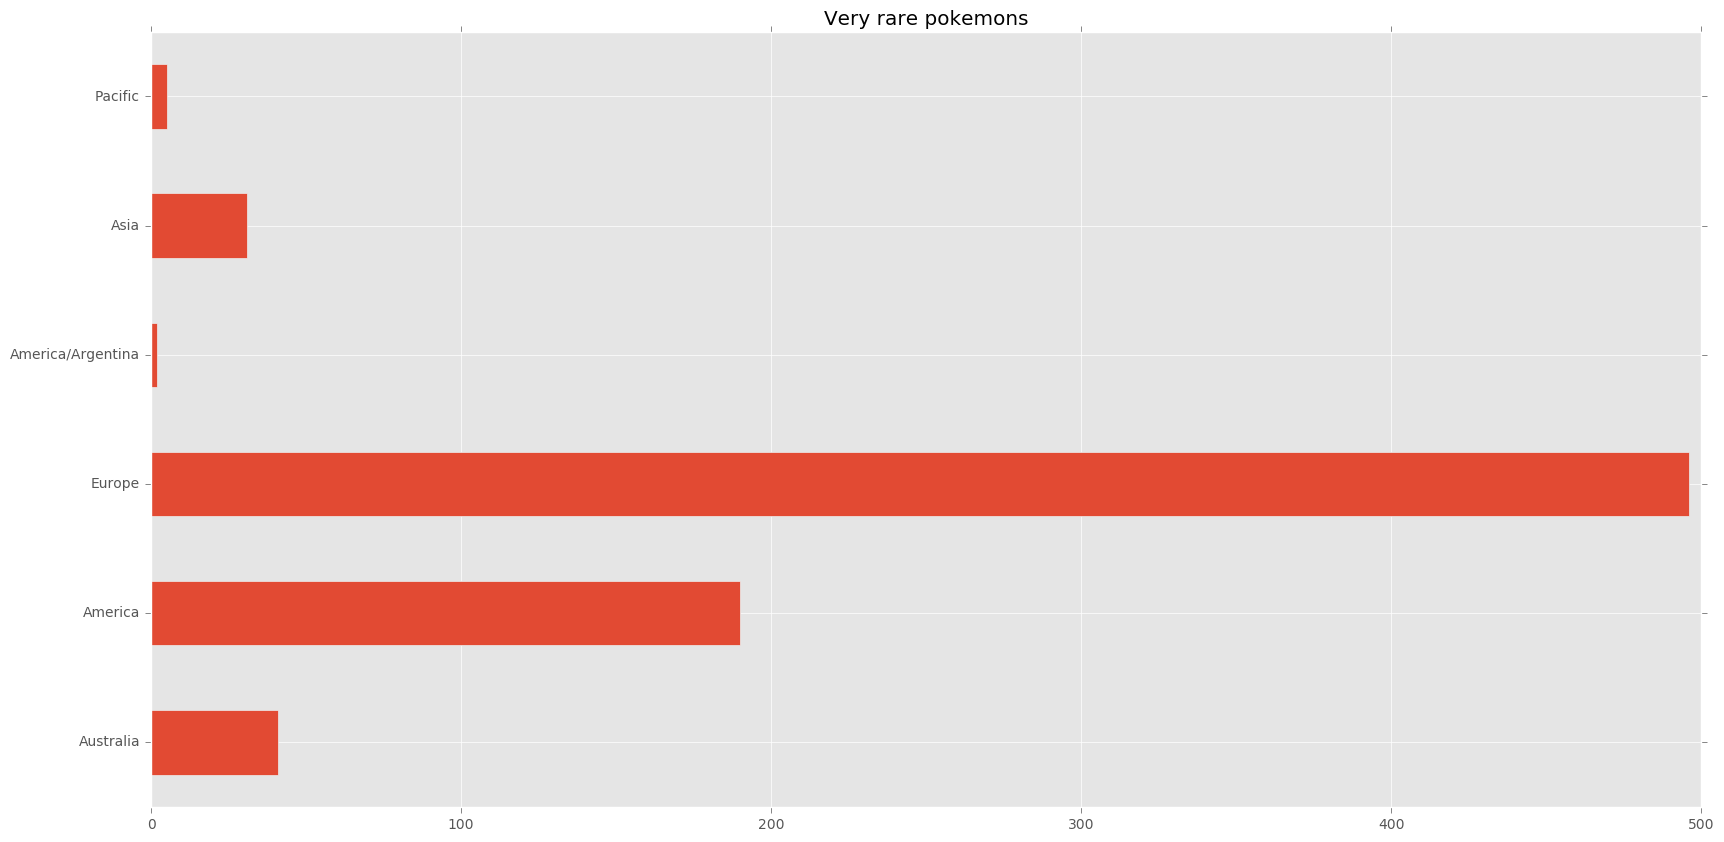

In [3]:
""" 
Statistical Analysis
"""

times = datas.appearedLocalTime.as_matrix()
time = np.array([datetime.strptime(d, '%Y-%m-%dT%H:%M:%S') for d in times])
datas['date'] = time
apHour = datas['appearedHour']
apHour -= 2 #time bias
apHour[apHour<0] += 24

# pokemon rareness distribution
fig = plt.figure(figsize=(20,10))
temp = pd.DataFrame.from_dict(Counter(datas['rareness']), orient = 'index')
temp.index = ['Common', 'Rare', 'Very rare']
temp.plot(kind='bar', figsize=(20,10), legend=False)
plt.title('Pokemon rareness distribution')


# pokemon sightings in each continent
continent = datas['continent']
fig= plt.subplots(figsize=(20,10))
pd.DataFrame.from_dict(Counter(continent), orient = 'index')\
.plot(kind='barh', legend=False)
plt.title('Common pokemons')

# rare pokemon sightings in each continent
continent = datas[datas.rareness==1]['continent']
pd.DataFrame.from_dict(Counter(continent), orient = 'index')\
.plot(kind='barh', legend=False)
plt.title('Rare pokemons')


# very rare pokemon sightings in each continent
continent = datas[datas.rareness==2]['continent']
fig = plt.figure(figsize=(20,10))
pd.DataFrame.from_dict(Counter(continent), orient = 'index').\
plot(kind='barh', figsize=(20,10), legend=False)
plt.title('Very rare pokemons')
plt.show()

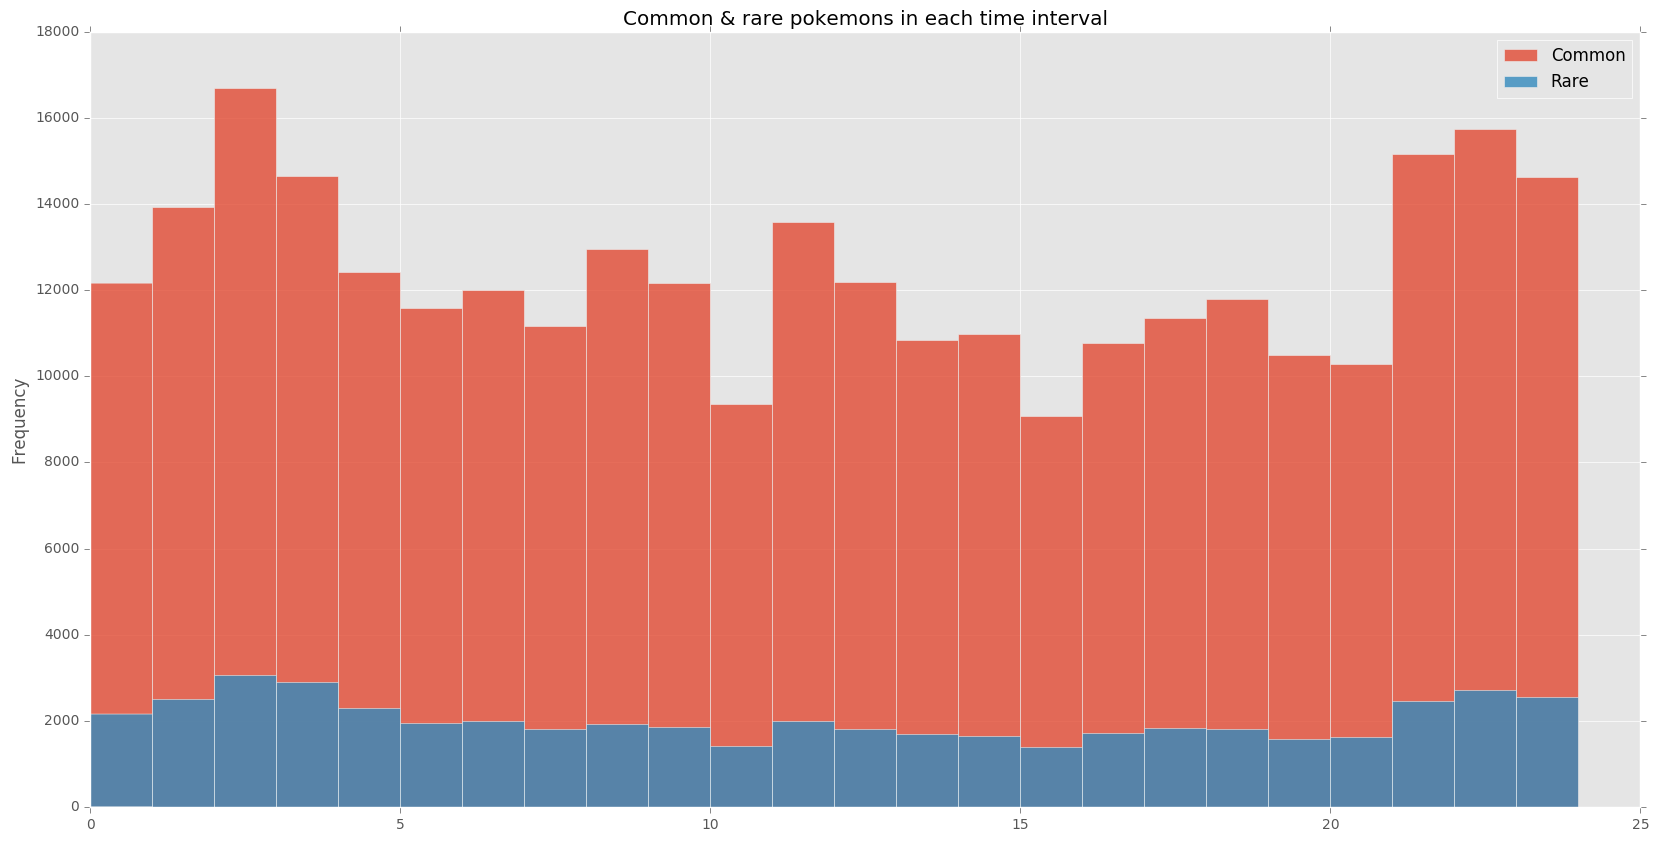

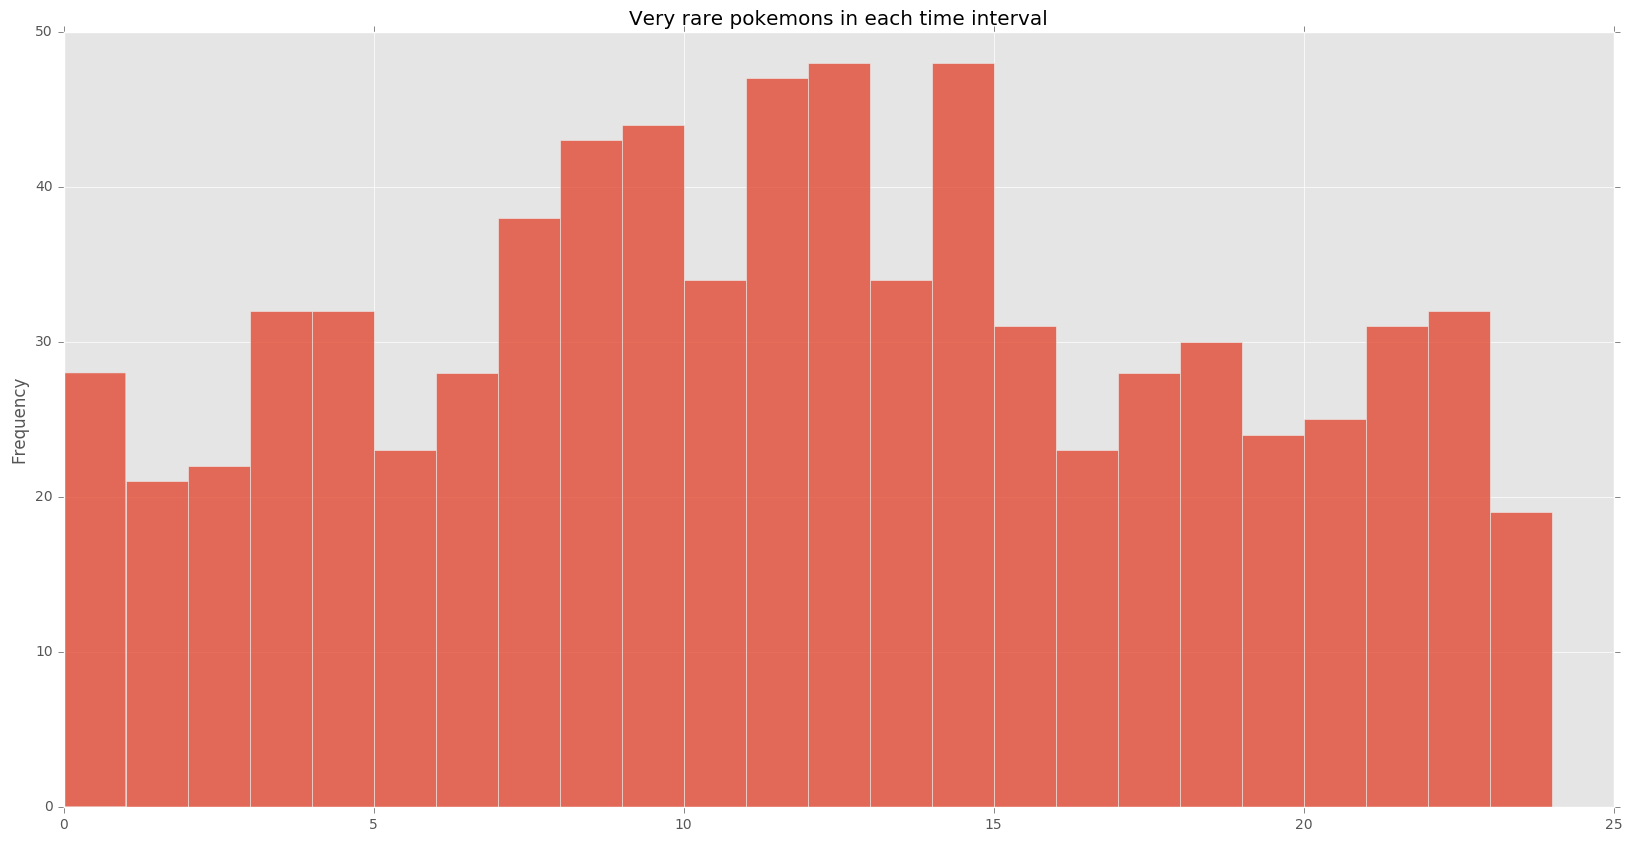

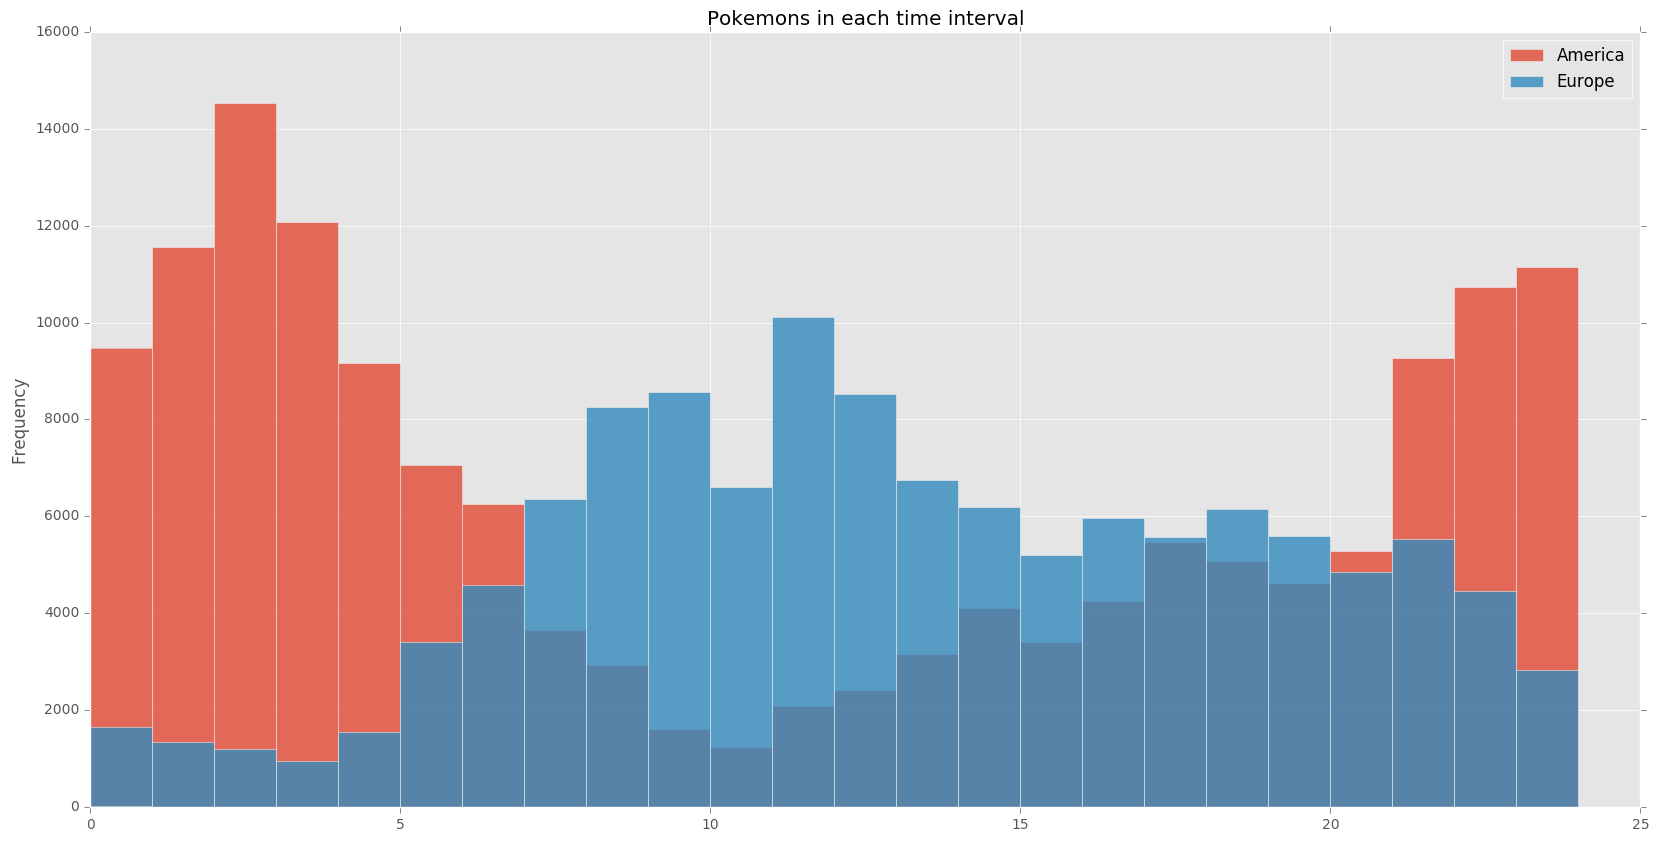

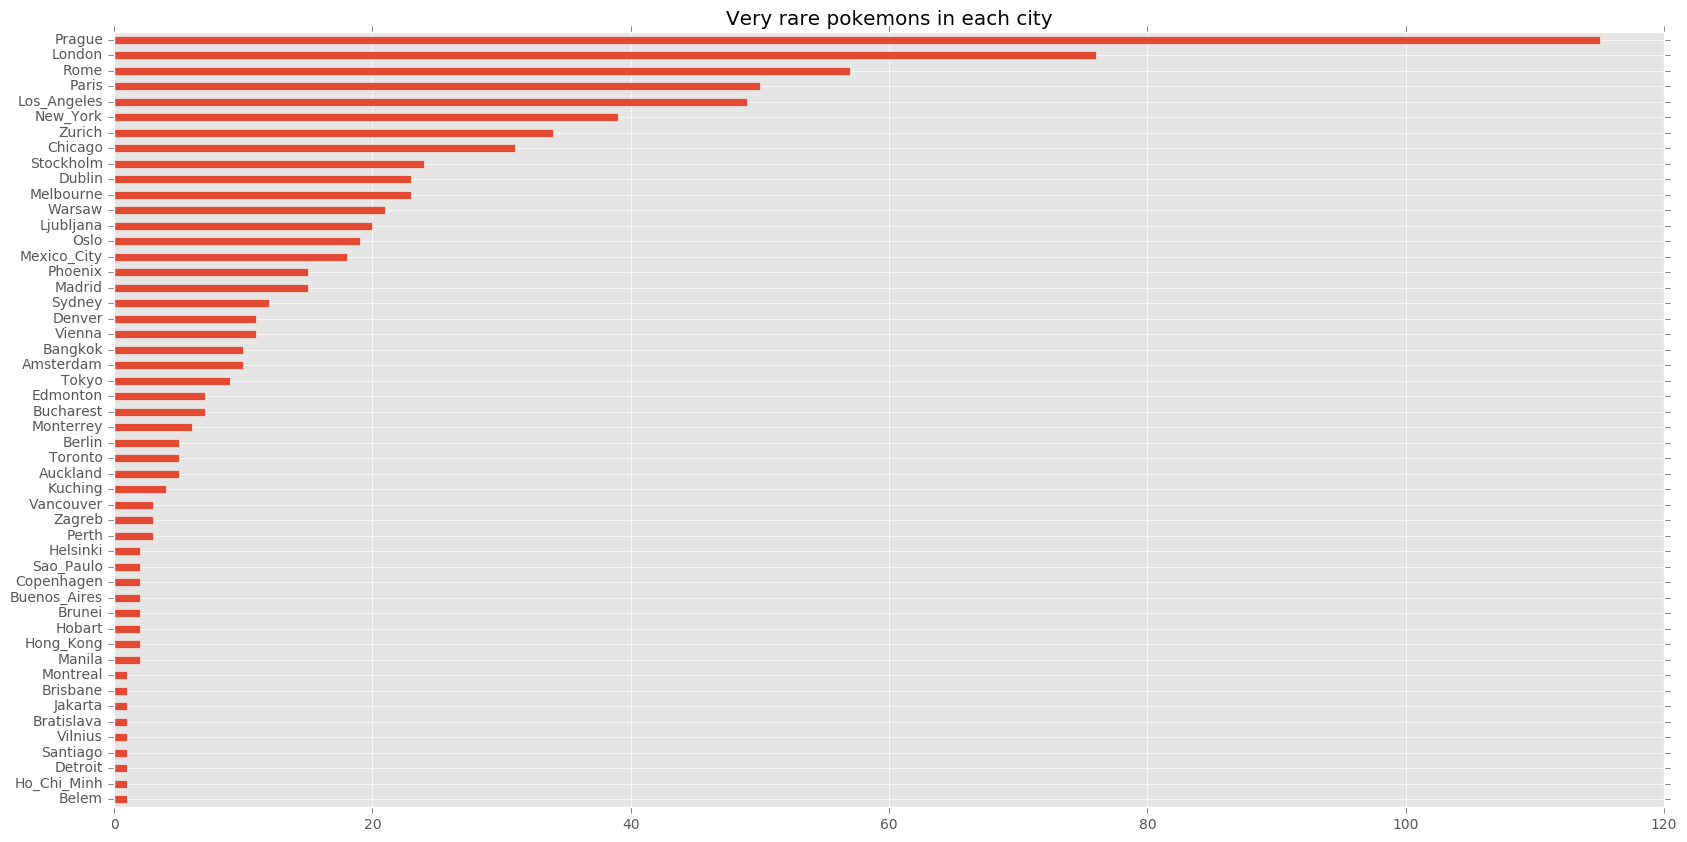

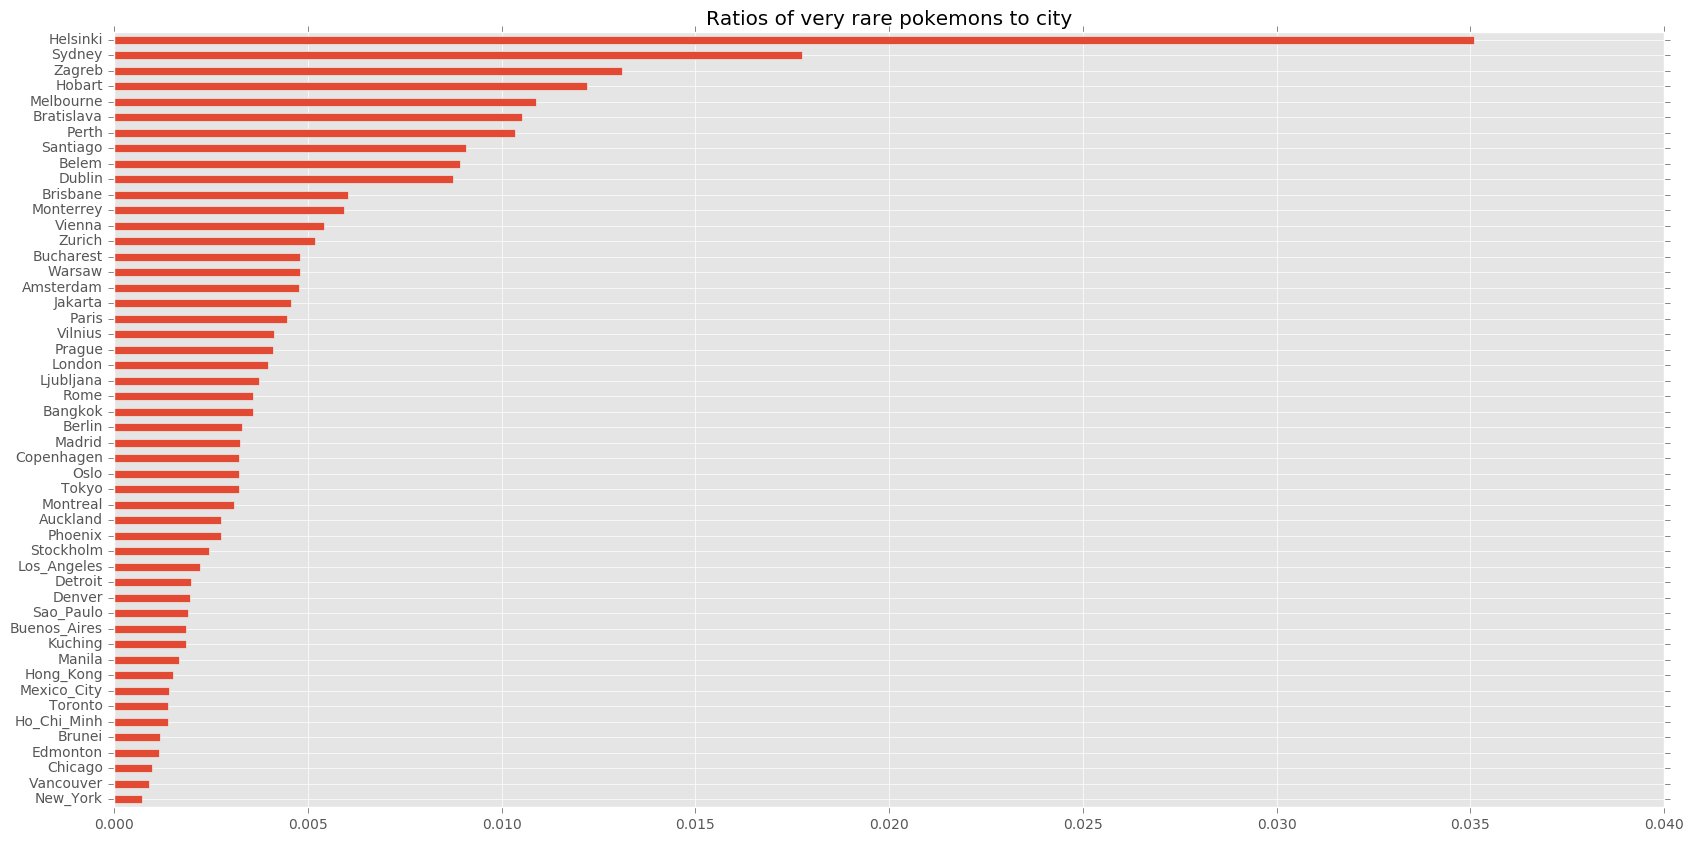

In [4]:
# all pokemon sightings in each local time interval
fig = plt.figure(figsize=(20,10))
apHour.plot.hist(bins=range(25), alpha=0.8) 

# rare pokemon sightings in each local time interval
datas[datas.rareness==1]['appearedHour'].plot.hist(bins=range(25), alpha=0.8)
plt.title('Common & rare pokemons in each time interval')
plt.legend(['Common', 'Rare'])

# very rare pokemon sightings in each local time interval
fig = plt.figure(figsize=(20,10))
datas[datas.rareness==2]['appearedHour'].plot.hist(bins=range(25), alpha=0.8)
plt.title('Very rare pokemons in each time interval' )

# all pokemon sightings in EU and America in each local time interval
Area = 'America'
apHourSpecificArea = datas[datas.continent == Area].appearedHour
fig = plt.figure(figsize=(20,10))
apHourSpecificArea.plot.hist(bins=range(25), alpha=0.8)
Area = 'Europe'
apHourSpecificArea = datas[datas.continent == Area].appearedHour
apHourSpecificArea.plot.hist(bins=range(25), alpha=0.8)
plt.legend(['America', 'Europe'])
plt.title('Pokemons in each time interval')

# very rare pokemon sightings in each city
city = datas[datas.rareness==2]['city']
fig = plt.figure(figsize=(20,10))
rareInCity = pd.DataFrame.from_dict(Counter(city), orient = 'index')
rareInCity = rareInCity.sort_values(by=0, ascending=1)
rareInCity.plot(kind='barh', figsize=(20,10), legend=False)
plt.title('Very rare pokemons in each city')

# very rare pokemon sightings ratio to city
commonCity = pd.DataFrame.from_dict(Counter(datas['city']), orient = 'index')
commonCity = commonCity[commonCity.index.isin(rareInCity.index)]
for i in rareInCity.index:
    rareInCity.loc[i] /= commonCity.loc[i]
rareInCity = rareInCity.sort_values(by=0, ascending=1)
fig = plt.figure(figsize=(20,10))
rareInCity.plot(kind='barh', figsize=(20,10), legend=False)
plt.title('Ratios of very rare pokemons to city')
plt.show()

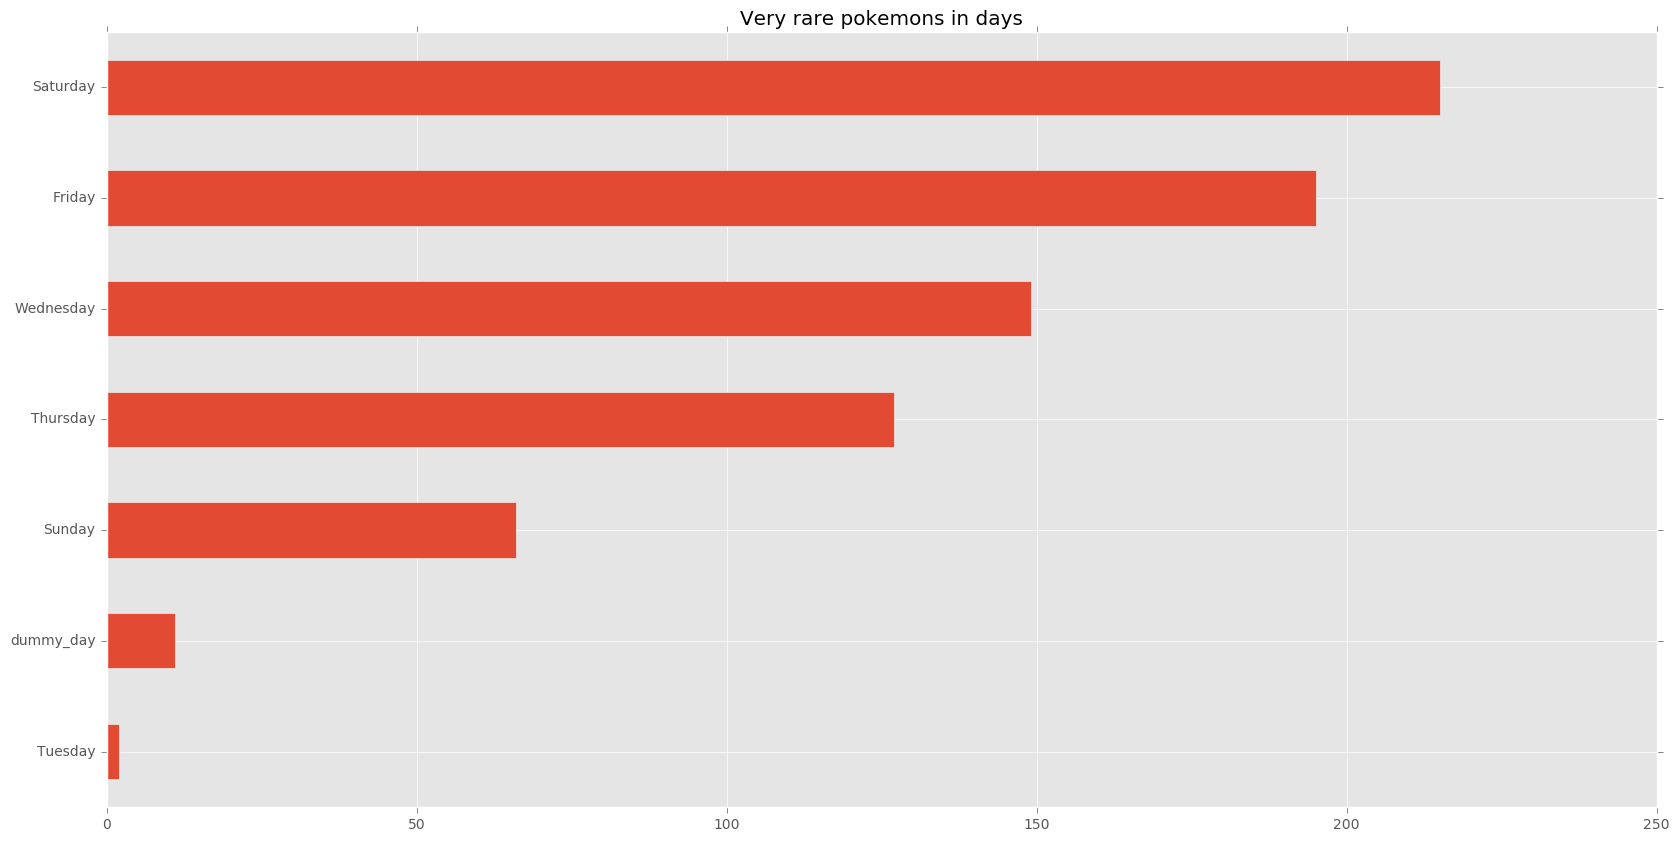

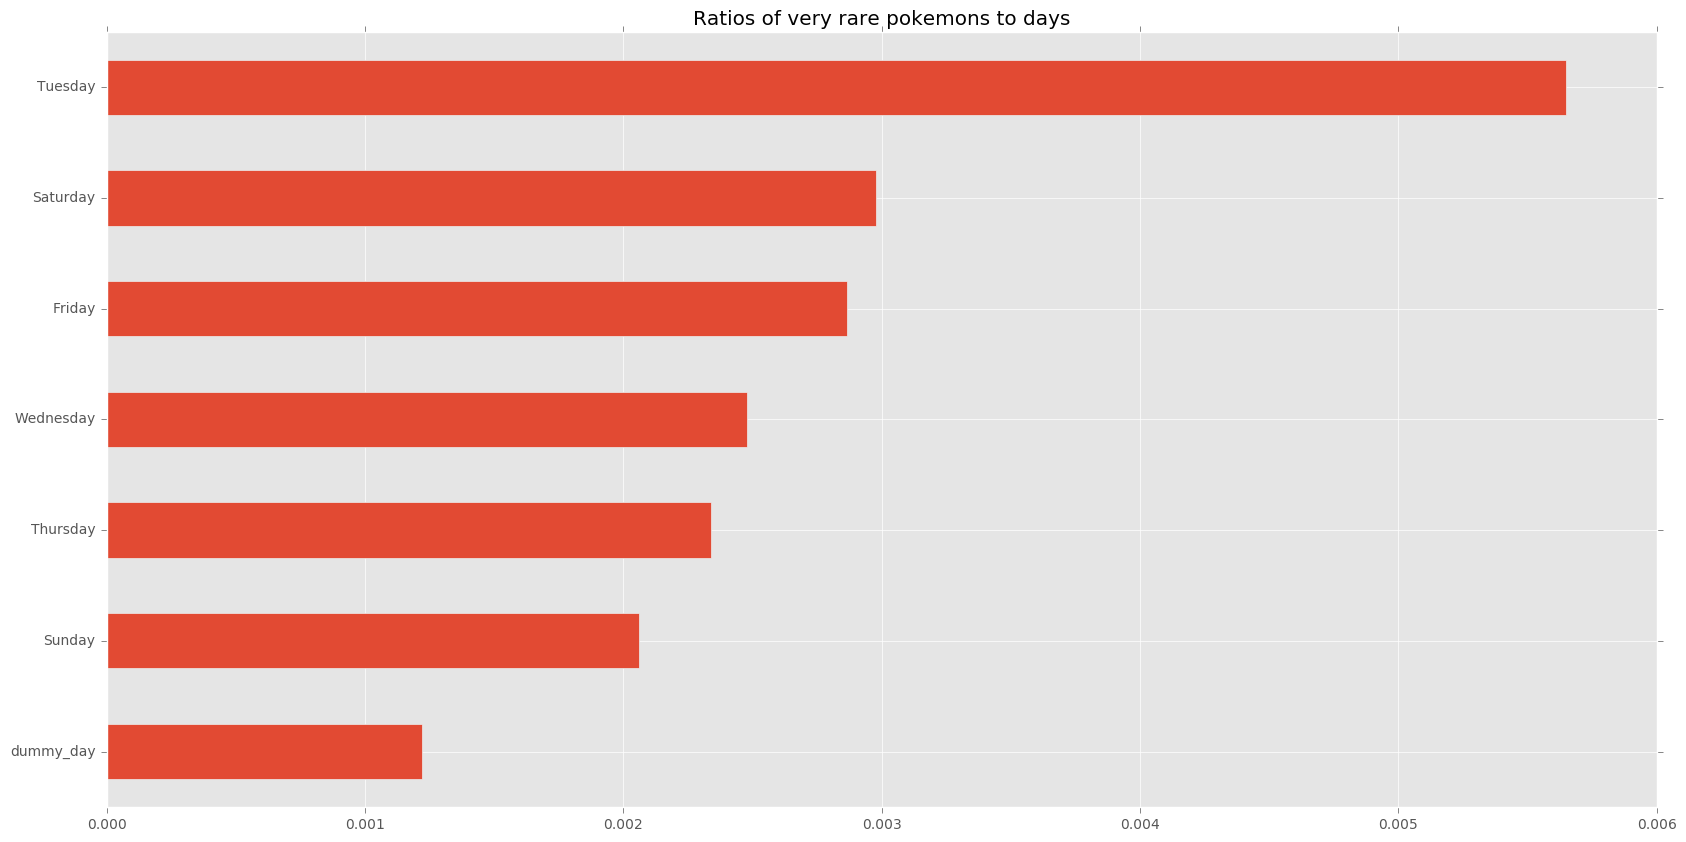

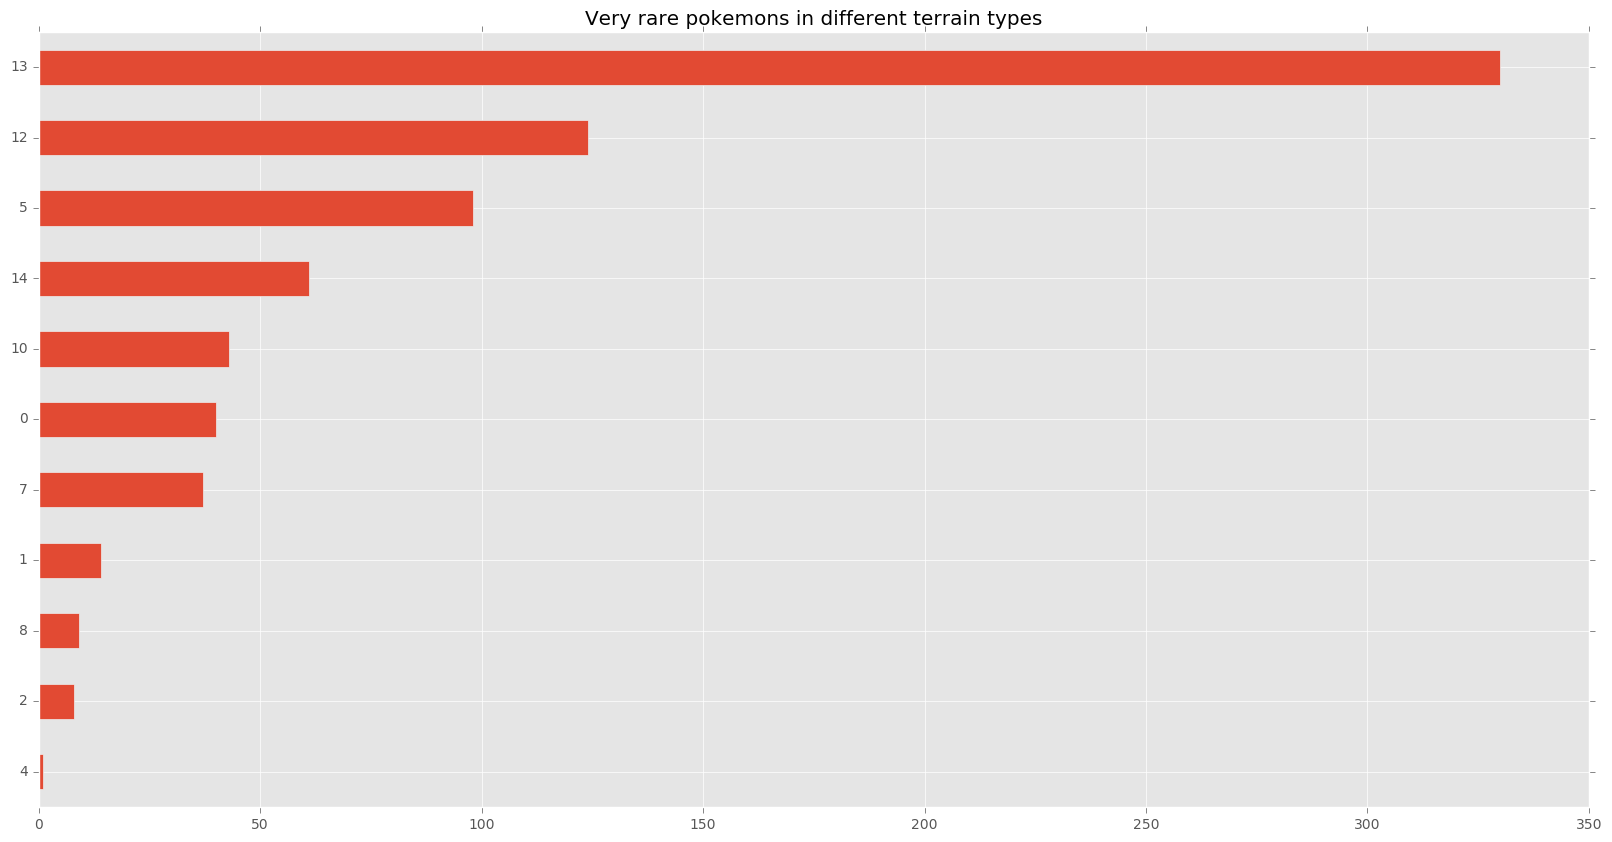

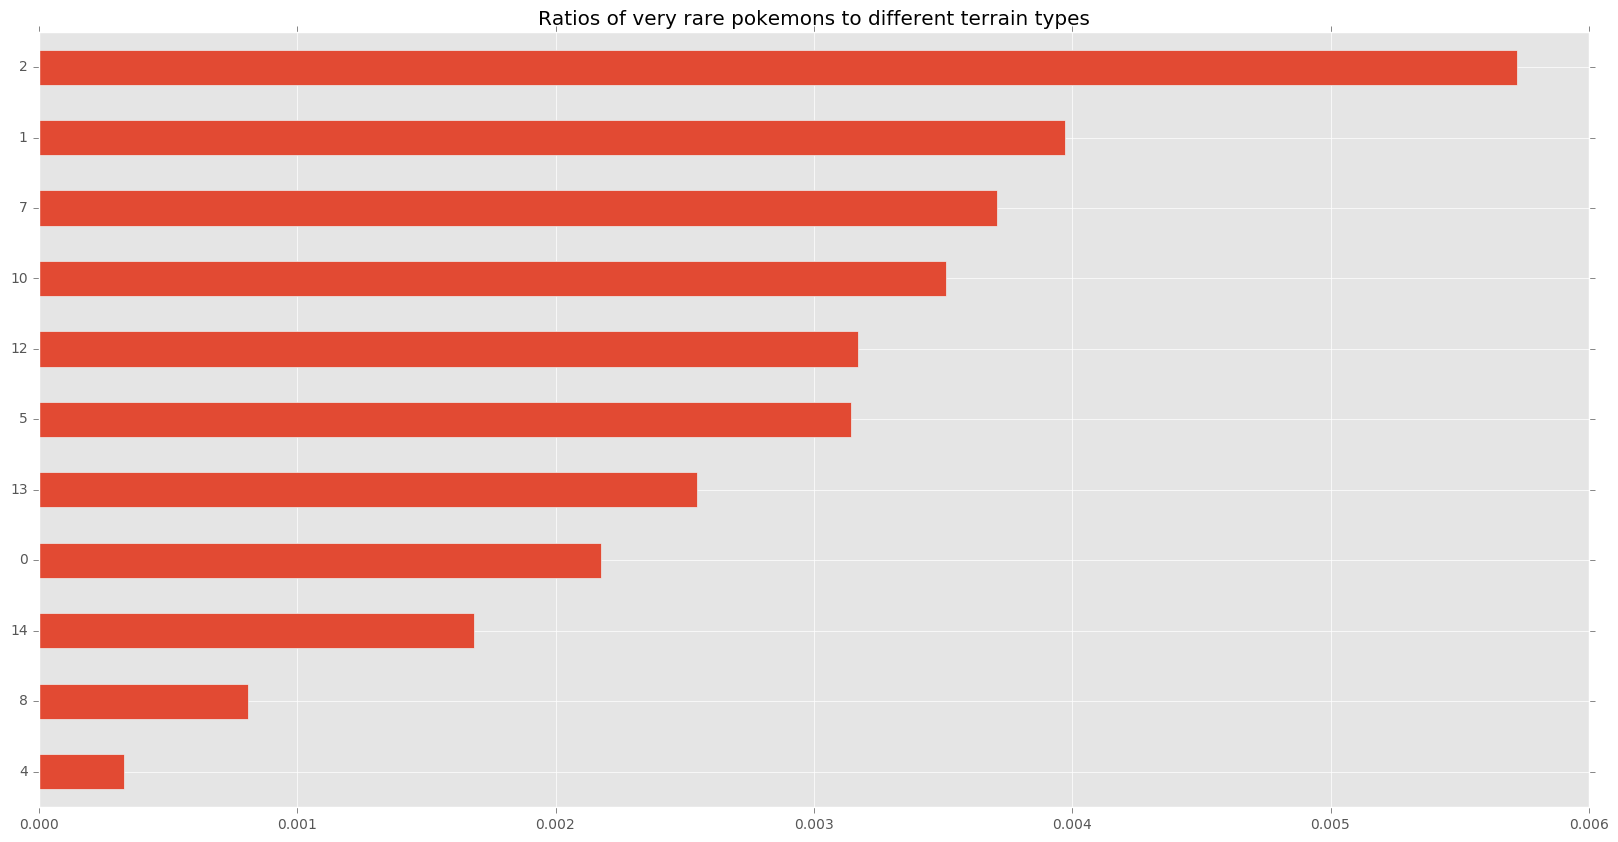

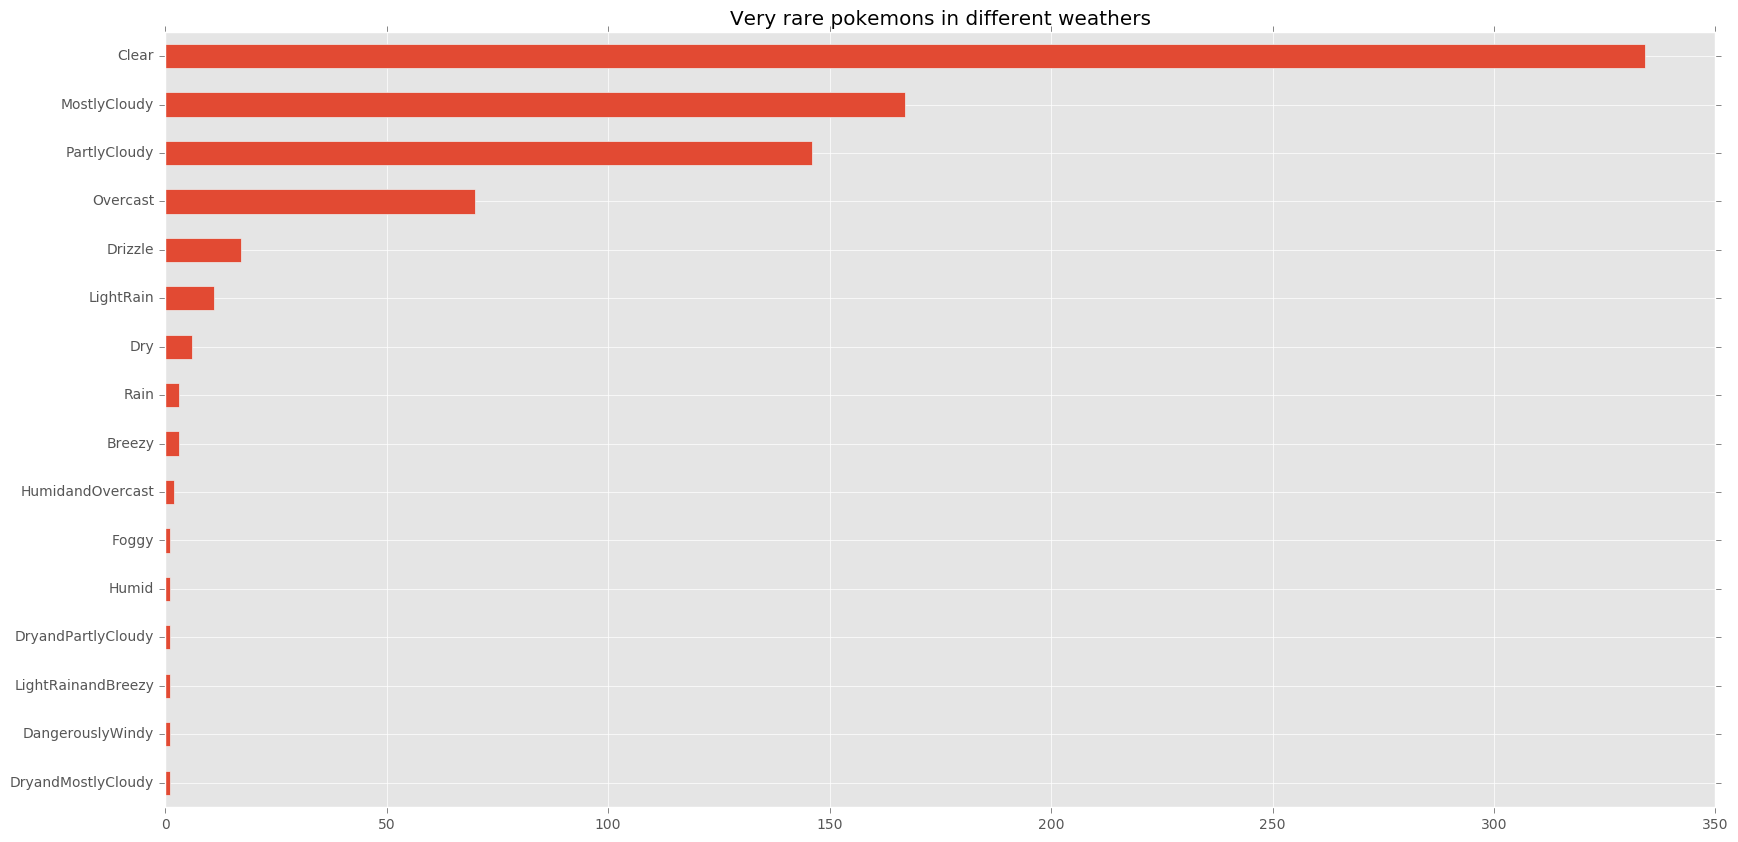

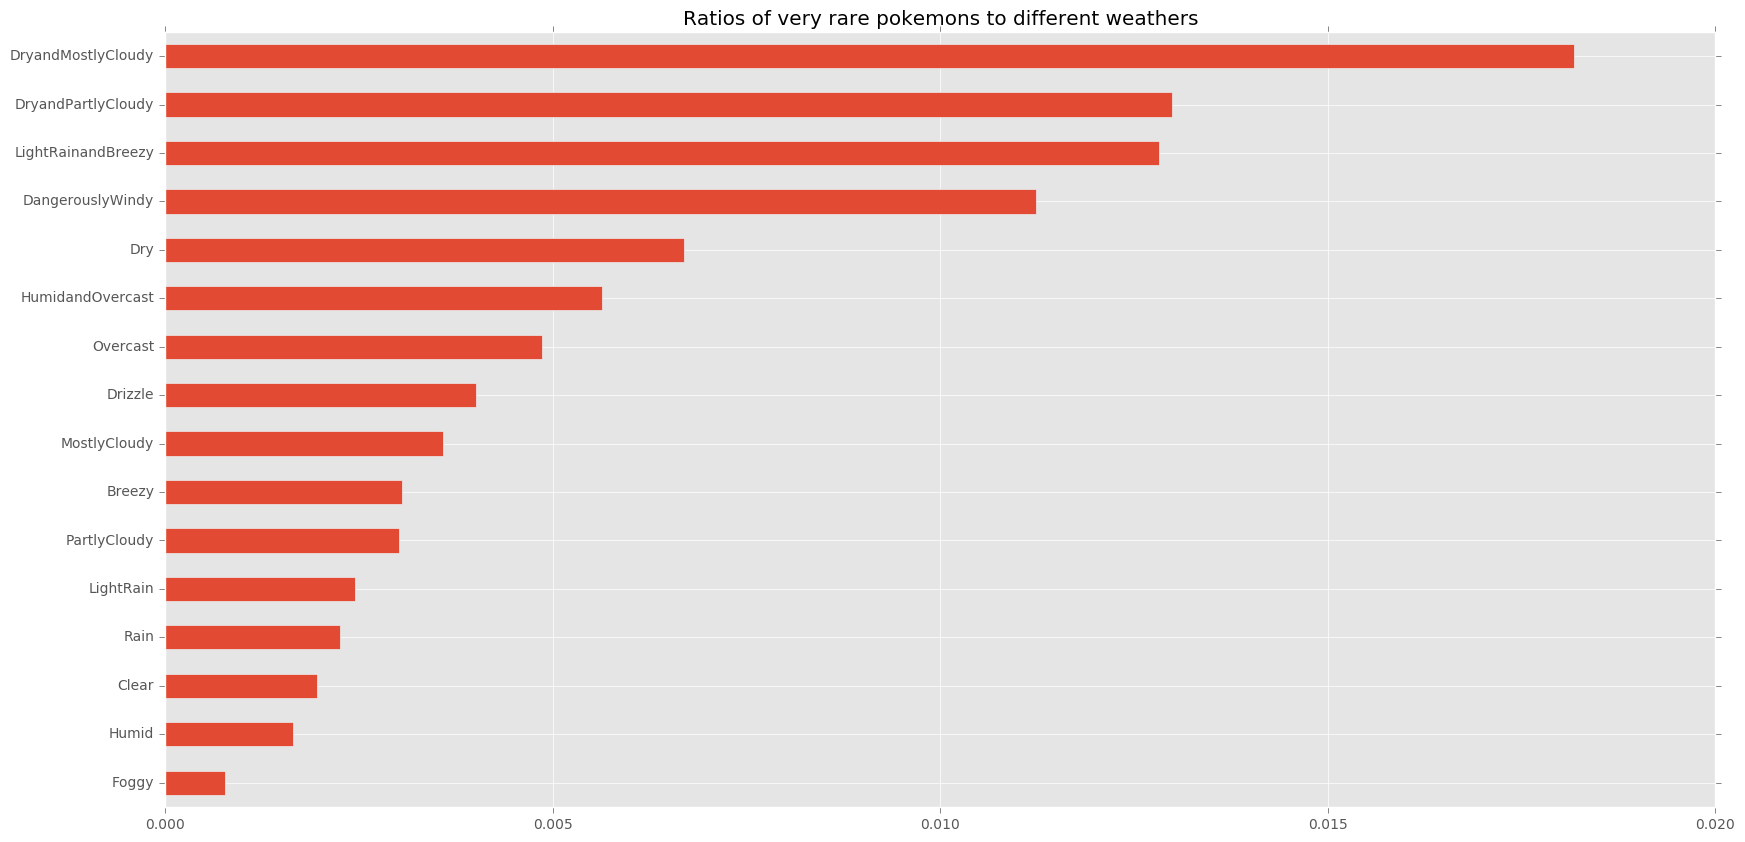

In [5]:
# very rare pokemon sightings among weekdays
dayOfWeek = datas[datas.rareness==2]['appearedDayOfWeek']
fig = plt.figure(figsize=(20,10))
rareDayOfWeek = pd.DataFrame.from_dict(Counter(dayOfWeek), orient = 'index')
rareDayOfWeek = rareDayOfWeek.sort_values(by=0, ascending=1)
rareDayOfWeek.plot(kind='barh', figsize=(20,10), legend=False)
plt.title('Very rare pokemons in days')

# very rare pokemon sightings ratio to weekdays
commonDayOfWeek = pd.DataFrame.from_dict(Counter(datas['appearedDayOfWeek']), 
                                    orient = 'index')
commonDayOfWeek = commonDayOfWeek[commonDayOfWeek.index.isin(rareDayOfWeek.index)]
for i in rareDayOfWeek.index:
    rareDayOfWeek.loc[i] /= commonDayOfWeek.loc[i]
rareDayOfWeek = rareDayOfWeek.sort_values(by=0, ascending=1)
fig = plt.figure(figsize=(20,10))
rareDayOfWeek.plot(kind='barh', figsize=(20,10), legend=False)
plt.title('Ratios of very rare pokemons to days')


# very rare pokemon sightings in different terrain types
terrain = datas[datas.rareness==2]['terrainType']
fig = plt.figure(figsize=(20,10))
rareTerrain = pd.DataFrame.from_dict(Counter(terrain), orient = 'index')
rareTerrain = rareTerrain.sort_values(by=0, ascending=1)
rareTerrain.plot(kind='barh', figsize=(20,10), legend=False)
plt.title('Very rare pokemons in different terrain types')

# very rare pokemon sightings ratio to terrain types
commonTerrain = pd.DataFrame.from_dict(Counter(datas['terrainType']), 
                                    orient = 'index')
commonTerrain = commonTerrain[commonTerrain.index.isin(rareTerrain.index)]
for i in rareTerrain.index:
    rareTerrain.loc[i] /= commonTerrain.loc[i]
rareTerrain = rareTerrain.sort_values(by=0, ascending=1)
fig = plt.figure(figsize=(20,10))
rareTerrain.plot(kind='barh', figsize=(20,10), legend=False)
plt.title('Ratios of very rare pokemons to different terrain types')



# very rare pokemon sightings in different weathers
weather = datas[datas.rareness==2]['weather']
fig = plt.figure(figsize=(20,10))
rareWeather = pd.DataFrame.from_dict(Counter(weather), orient = 'index')
rareWeather = rareWeather.sort_values(by=0, ascending=1)
rareWeather.plot(kind='barh', figsize=(20,10), legend=False)
plt.title('Very rare pokemons in different weathers')


# very rare pokemon sightings ratio to weathers
commonWeather = pd.DataFrame.from_dict(Counter(datas['weather']), 
                                    orient = 'index')
commonWeather = commonWeather[commonWeather.index.isin(rareWeather.index)]
for i in rareWeather.index:
    rareWeather.loc[i] /= commonWeather.loc[i]
rareWeather = rareWeather.sort_values(by=0, ascending=1)
fig = plt.figure(figsize=(20,10))
rareWeather.plot(kind='barh', figsize=(20,10), legend=False)
plt.title('Ratios of very rare pokemons to different weathers')
plt.show()


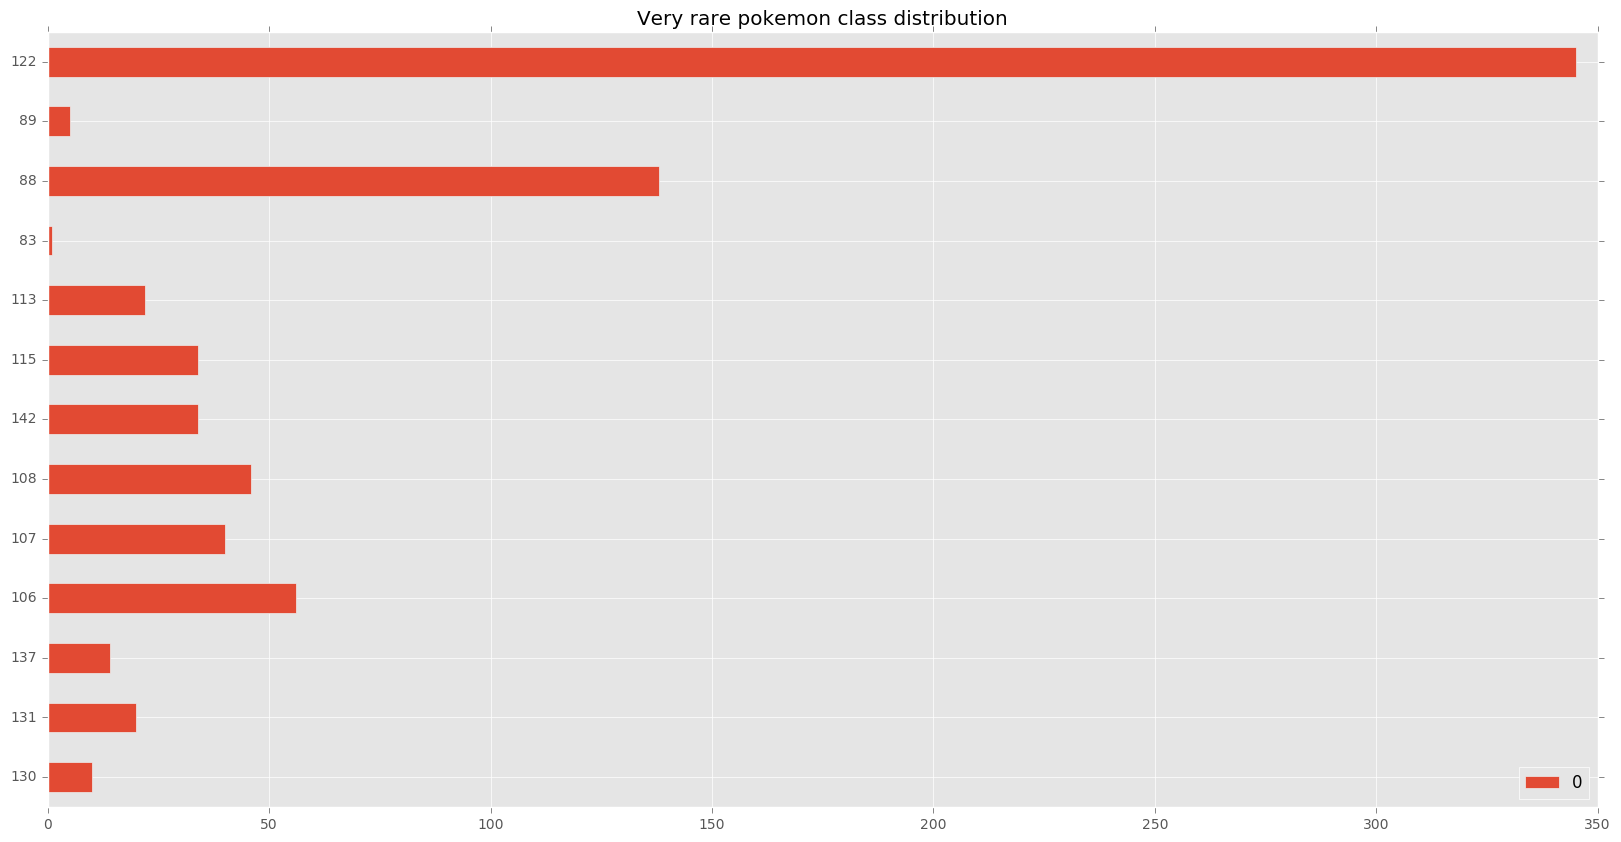

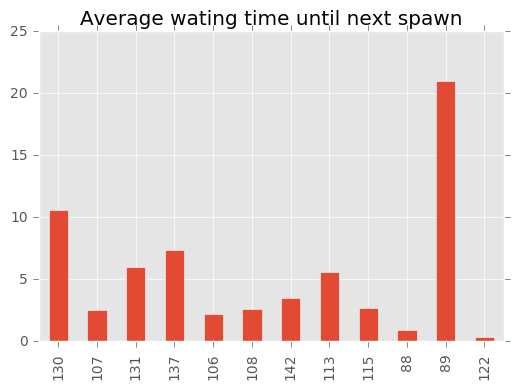

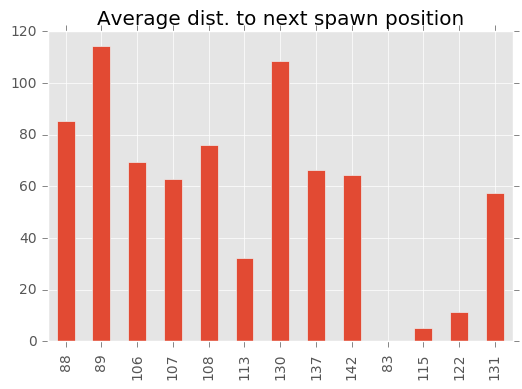

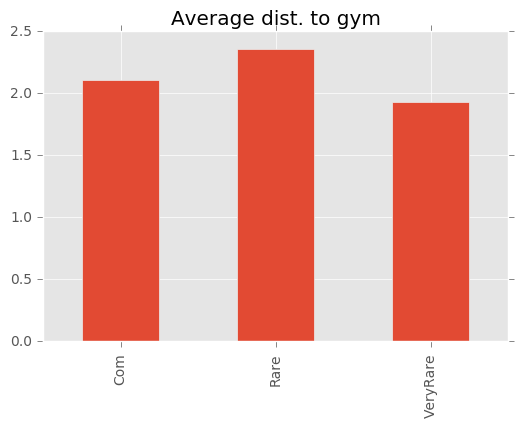

In [6]:
#Rare pokemons sightings count
veryRarePokemon = datas[datas.rareness == 2]
veryRarePokemonClass = veryRarePokemon.pokemonId
fig = pd.DataFrame.from_dict(Counter(veryRarePokemonClass), orient = 'index')
fig = fig.plot(kind='barh', figsize=(20,10))
plt.title('Very rare pokemon class distribution')
    
#rare pokemon average sighting time and distance
avgRareTime = pd.DataFrame(columns=['avgTime'])
avgRareDist = pd.DataFrame(columns=['avgDist'])
veryRarePokemon = veryRarePokemon.sort_values(by='date')
for i in veryRareId:
    temp = veryRarePokemon[veryRarePokemon.pokemonId==i]['date']
    if temp.empty != 1:
        tempSum = temp.diff().sum()
        avgRareTime.loc[i] = (tempSum / temp.size)
        tempLat = veryRarePokemon[veryRarePokemon.pokemonId==i]['latitude'].diff()
        tempLon = veryRarePokemon[veryRarePokemon.pokemonId==i]['longitude'].diff()
        tempLat *= 1.112
        tempLon *= 1.024
        tempLat *= tempLat
        tempLon *= tempLon
        tempDist = tempLat + tempLon
        tempDist = tempDist.apply(np.sqrt)
        avgRareDist.loc[i] = tempDist.mean()
fig = plt.figure(figsize=(20,10))
avgRT = avgRareTime['avgTime'].to_dict()
del avgRT[83]
for i in avgRT:
    avgRT[i] = avgRT[i].seconds / 3600
pd.DataFrame.from_dict(avgRT, orient='index')\
.plot(kind='bar', title='Average wating time until next spawn', 
      legend=False)

fig = plt.figure(figsize=(20,10))
avgRareDist.plot(kind='bar', title='Average dist. to next spawn position',
                 legend=False)
    


# average distance from pokemon sightings to nearest gym
avgGymDist = np.array([])
avgGymDist = np.append(avgGymDist,
                       datas[datas.rareness==0]['gymDistanceKm'].mean())
avgGymDist = np.append(avgGymDist,
                       datas[datas.rareness==1]['gymDistanceKm'].mean())
avgGymDist = np.append(avgGymDist,
                       datas[datas.rareness==2]['gymDistanceKm'].mean())
avgGymDist = pd.DataFrame(avgGymDist)
avgGymDist.index = ['Com', 'Rare', 'VeryRare']
avgGymDist.plot(kind='bar', title='Average dist. to gym', legend=False)
plt.show()


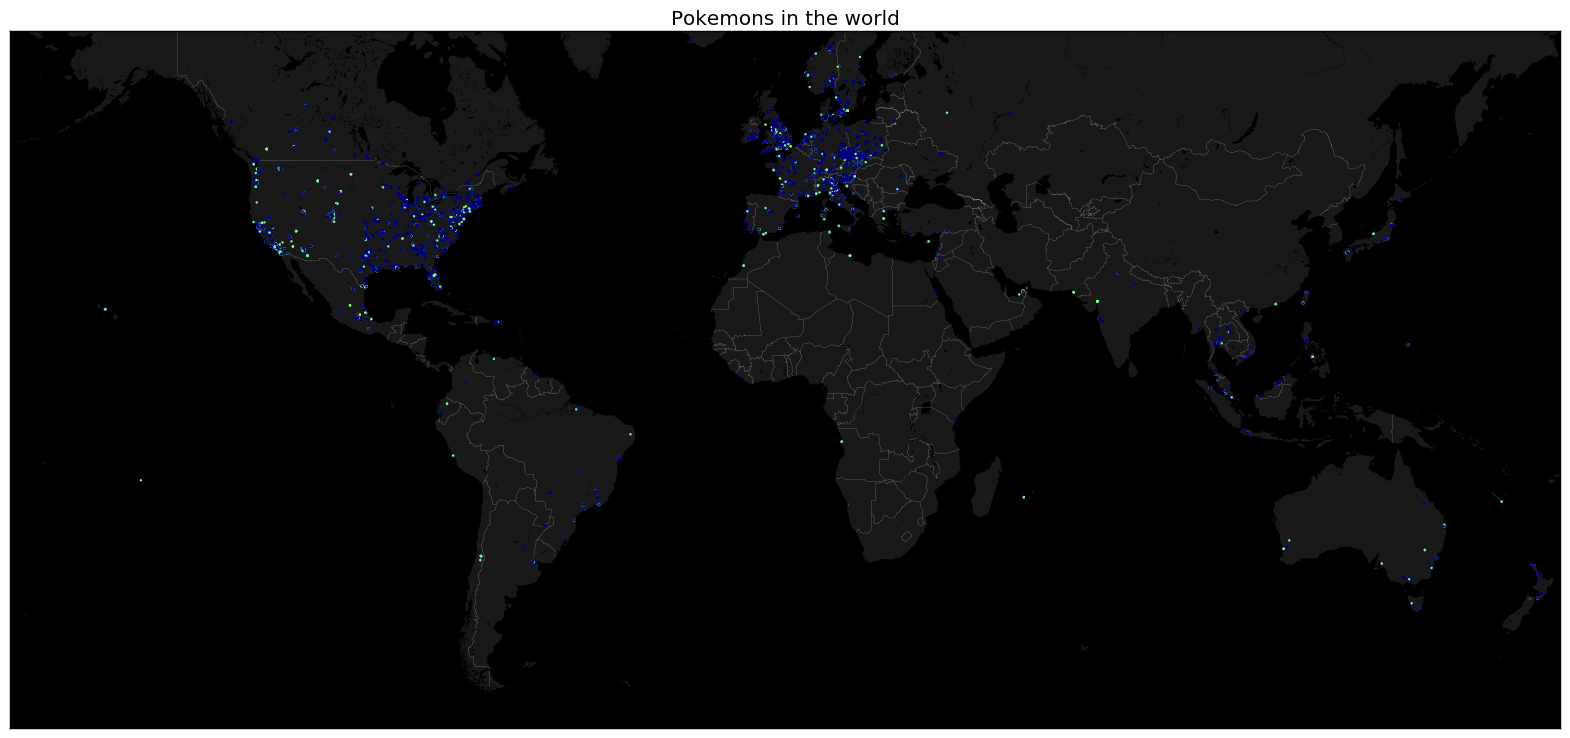

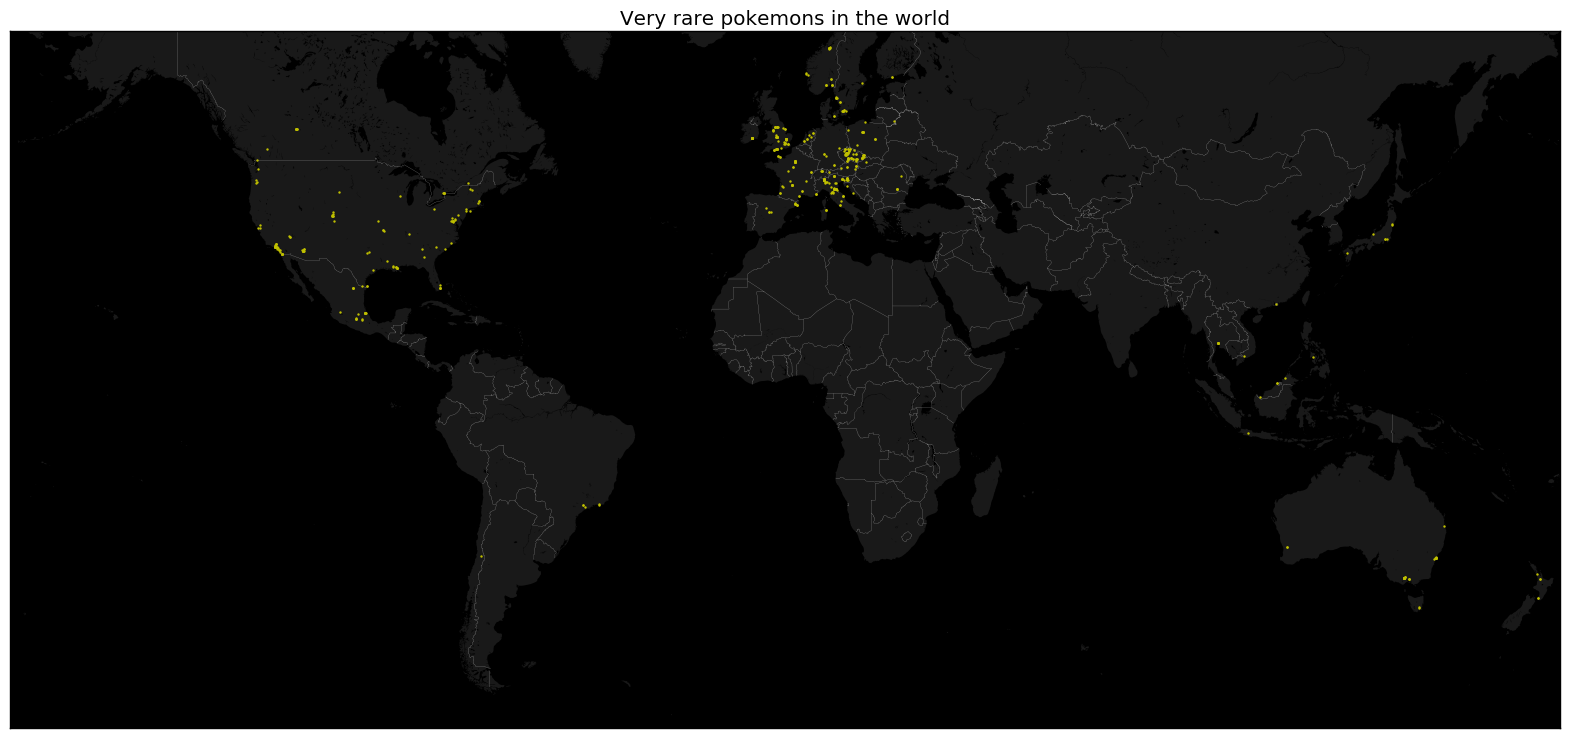

In [7]:
"""
Draw sightings on world maps
"""

###### Draw all pokemons on the map ######
fig = plt.figure(figsize=(20,10))
bm = Basemap(projection='merc',
             llcrnrlat=-60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='i')

# Draw the coastlines on the map
bm.fillcontinents(color='#191919',lake_color='#000000') 
bm.drawmapboundary(fill_color='#000000')                
bm.drawcountries(linewidth=0.1, color="w") 
plt.title('Pokemons in the world')
x, y = bm(train.longitude.tolist(), 
          train.latitude.tolist())
bm.scatter(x,y, s=3, c=train.rareness, lw=0, alpha=1, zorder=5)

###### Draw very rare pokemons on the map ######
fig = plt.figure(figsize=(20,10))
bm = Basemap(projection='merc',
             llcrnrlat=-60,
             urcrnrlat=65,
             llcrnrlon=-180,
             urcrnrlon=180,
             lat_ts=0,
             resolution='i')

# Draw the coastlines on the map
bm.fillcontinents(color='#191919',lake_color='#000000')
bm.drawmapboundary(fill_color='#000000')               
bm.drawcountries(linewidth=0.1, color="w") 
plt.title('Very rare pokemons in the world')
x, y = bm(train[train['rareness']==2].longitude.tolist(), 
          train[train['rareness']==2].latitude.tolist())
bm.scatter(x,y, s=3, c="y", lw=0, alpha=1, zorder=5, marker="o")
plt.show()


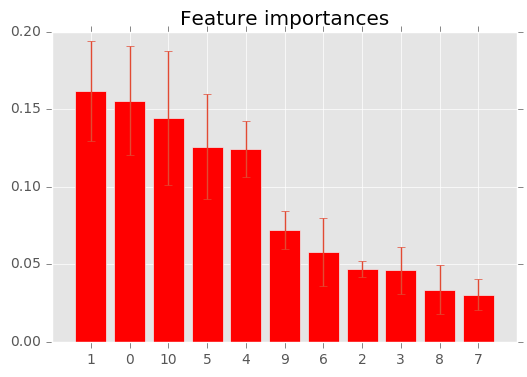

---Random forest model with all sightings in the world---
    Class predict accuracy: 18.275483%


In [9]:
"""
Model trained with all pokemon sightings
"""

trainFeatures = train[featureSelected]
trainLabels = train['pokemonId'].as_matrix()
testFeatures = test[featureSelected]
testLabels = test['pokemonId'].as_matrix()
    
#PCA
pca = PCA(n_components=5)
pca.fit(trainFeatures)
pcaTrainFeatures = pca.transform(trainFeatures)
pcaTestFeatures = pca.transform(testFeatures)

#LDA
lda = LDA(n_components=5)
lda.fit(trainFeatures, trainLabels)
ldaTrainFeatures = lda.transform(trainFeatures)
ldaTestFeatures = lda.transform(testFeatures)

#Logistic Regression
#lrModel = LogisticRegression()
#lrModel.fit(trainFeatures, trainLabels)
#acc = lrModel.score(testFeatures, testLabels)
#
#lrModel = LogisticRegression()
#lrModel.fit(pcaTrainFeatures, trainLabels)
#acc1 = lrModel.score(pcaTestFeatures, testLabels)
#
#lrModel = LogisticRegression()
#lrModel.fit(ldaTrainFeatures, trainLabels)
#acc2 = lrModel.score(ldaTestFeatures, testLabels)

#Forest
forest = ExtraTreesClassifier(n_estimators=10,
                              max_depth=10,
                              random_state=0)
forest.fit(trainFeatures, trainLabels)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(trainFeatures.iloc[0].size), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(trainFeatures.iloc[0].size), indices)
plt.xlim([-1, trainFeatures.iloc[0].size])
plt.show()

predictLabel = []
for i in range(0, testFeatures.shape[0]):
    predictLabel.append(forest.predict(testFeatures.iloc[i]))
temp = np.array(predictLabel)
temp = temp.reshape(temp.shape[0])
acc = sum(np.equal(temp, testLabels)) / temp.shape[0]
print('---Random forest model with all sightings in the world---')
print('    Class predict accuracy: %f%%' %(acc*100))



In [10]:
"""
Model trained with rare pokemon sightings only
"""

trainFeaturesRare = train[(train.rareness==2)][featureSelected]
trainLabelsRare = train[(train.rareness==2)]['pokemonId'].as_matrix()
testFeaturesRare = test[(test.rareness==2)][featureSelected]
testLabelsRare = test[(test.rareness==2)]['pokemonId'].as_matrix()
    
#PCA
pca = PCA(n_components=3)
pca.fit(trainFeaturesRare)
pcaTrainFeatures = pca.transform(trainFeaturesRare)
pcaTestFeatures = pca.transform(testFeaturesRare)

#LDA
lda = LDA(n_components=3)
lda.fit(trainFeaturesRare, trainLabelsRare)
ldaTrainFeatures = lda.transform(trainFeaturesRare)
ldaTestFeatures = lda.transform(testFeaturesRare)

#Random Forest model  
forest = RandomForestClassifier(max_depth=20,
                                n_estimators=20, 
                                )
forest.fit(trainFeaturesRare, trainLabelsRare)
predictLabel = []
for i in range(0, testFeaturesRare.shape[0]):
    predictLabel.append(forest.predict(testFeaturesRare.iloc[i]))
temp = np.array(predictLabel)
temp = temp.reshape(temp.shape[0])
acc = sum(np.equal(temp, testLabelsRare)) / temp.shape[0]
print('---Random forest model with very rare sightings in the world---')
print('    Class predict accuracy: %f%%' %(acc*100))




trainFeaturesRare = train[(train.rareness==2)&(train.continent=='America')\
                          ][featureSelected]
trainLabelsRare = train[(train.rareness==2)&(train.continent=='America')\
                        ]['pokemonId'].as_matrix()
testFeaturesRare = test[(test.rareness==2)&(test.continent=='America')\
                        ][featureSelected]
testLabelsRare = test[(test.rareness==2)&(test.continent=='America')\
                      ]['pokemonId'].as_matrix()
    
#PCA
pca = PCA(n_components=3)
pca.fit(trainFeaturesRare)
pcaTrainFeatures = pca.transform(trainFeaturesRare)
pcaTestFeatures = pca.transform(testFeaturesRare)

#LDA
lda = LDA(n_components=3)
lda.fit(trainFeaturesRare, trainLabelsRare)
ldaTrainFeatures = lda.transform(trainFeaturesRare)
ldaTestFeatures = lda.transform(testFeaturesRare)

#Random Forest model  
forest = RandomForestClassifier(max_depth=20,
                                n_estimators=20, 
                                )
forest.fit(trainFeaturesRare, trainLabelsRare)
predictLabel = []
for i in range(0, testFeaturesRare.shape[0]):
    predictLabel.append(forest.predict(testFeaturesRare.iloc[i]))
temp = np.array(predictLabel)
temp = temp.reshape(temp.shape[0])
acc = sum(np.equal(temp, testLabelsRare)) / temp.shape[0]
print('---Random forest model with very rare sightings in America---')
print('    Class predict accuracy: %f%%' %(acc*100))



trainFeaturesRare = train[(train.rareness==2)&(train.continent=='Europe')\
                          ][featureSelected]
trainLabelsRare = train[(train.rareness==2)&(train.continent=='Europe')\
                        ]['pokemonId'].as_matrix()
testFeaturesRare = test[(test.rareness==2)&(test.continent=='Europe')\
                        ][featureSelected]
testLabelsRare = test[(test.rareness==2)&(test.continent=='Europe')\
                      ]['pokemonId'].as_matrix()
    
#PCA
pca = PCA(n_components=3)
pca.fit(trainFeaturesRare)
pcaTrainFeatures = pca.transform(trainFeaturesRare)
pcaTestFeatures = pca.transform(testFeaturesRare)

#LDA
lda = LDA(n_components=3)
lda.fit(trainFeaturesRare, trainLabelsRare)
ldaTrainFeatures = lda.transform(trainFeaturesRare)
ldaTestFeatures = lda.transform(testFeaturesRare)

#Random Forest model  
forest = RandomForestClassifier(max_depth=20,
                                n_estimators=20, 
                                )
forest.fit(trainFeaturesRare, trainLabelsRare)
predictLabel = []
for i in range(0, testFeaturesRare.shape[0]):
    predictLabel.append(forest.predict(testFeaturesRare.iloc[i]))
temp = np.array(predictLabel)
temp = temp.reshape(temp.shape[0])
acc = sum(np.equal(temp, testLabelsRare)) / temp.shape[0]
print('---Random forest model with very rare sightings in Europe---')
print('    Class predict accuracy: %f%%' %(acc*100))



##PCA
#forest = RandomForestClassifier(max_depth=20,
#                                n_estimators=20, 
#                                )
#forest.fit(pcaTrainFeatures, trainLabelsRare)
#predictLabel = []
#for i in range(0, pcaTestFeatures.shape[0]):
#    predictLabel.append(forest.predict(pcaTestFeatures[i]))
#temp = np.array(predictLabel)
#temp = temp.reshape(temp.shape[0])
#acc1 = sum(np.equal(temp, testLabelsRare)) / temp.shape[0]
#
##LDA
#forest = RandomForestClassifier(max_depth=20,
#                                n_estimators=20, 
#                                )
#forest.fit(ldaTrainFeatures, trainLabelsRare)
#predictLabel = []
#for i in range(0, ldaTestFeatures.shape[0]):
#    predictLabel.append(forest.predict(ldaTestFeatures[i]))
#temp = np.array(predictLabel)
#temp = temp.reshape(temp.shape[0])
#acc2 = sum(np.equal(temp, testLabelsRare)) / temp.shape[0]



---Random forest model with very rare sightings in the world---
    Class predict accuracy: 57.718121%
---Random forest model with very rare sightings in America---
    Class predict accuracy: 38.235294%
---Random forest model with very rare sightings in Europe---
    Class predict accuracy: 62.626263%
